In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tools.hetnet_file_processing import read_reactome
from tools.processing import regularize_colnames, head, expand_col_on_char, \
                                        combine_group_rows_on_char, load_api_results
from hetnet_ml.src import graph_tools as gt

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

load_dir = Path('../2_pipeline/00_download_data/out/').resolve()
network_dir = load_dir.parent.parent.joinpath('04_Incorporating_reactome/out')

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
// hack to get the filename for this notebook

<IPython.core.display.Javascript object>

In [3]:
out_dir = Path('../2_pipeline/').joinpath(nb_name.split('.')[0]).joinpath('out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
colors = sns.color_palette(["#4f8c9d", "#e23209", "#77be20", "#a34ddf", "#34f50e", "#871d32", "#18d19b"])
sns.set_palette(colors)

In [5]:
all_nodes = gt.remove_colons(pd.read_csv(network_dir.joinpath('nodes_all.csv'), dtype=str))
edges = gt.remove_colons(pd.read_csv(network_dir.joinpath('edges.csv'), dtype=str))

In [6]:
all_node_ids = all_nodes['id'].values
new_nodes = []
new_edges = []

In [7]:
all_nodes.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
0,MESH:C089250,(0.017ferrocene)amylose,Compound,D01.490.200/C089250|D02.691.550.200/C089250|D0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C114385,001-C8-NBD,Compound,D03.383.129.462.580/C114385|D12.644.456/C114385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# GO to Gene Relationships...

In [8]:
gene_term_edges = edges.query('abbv in {}'.format(['GeMF', 'GpoCC', 'GinBP']))

In [9]:
terms_per_gene = gene_term_edges.groupby(['start_id', 'abbv']).apply(len)
terms_per_gene = terms_per_gene.to_frame().reset_index().rename(columns={0: 'count'})

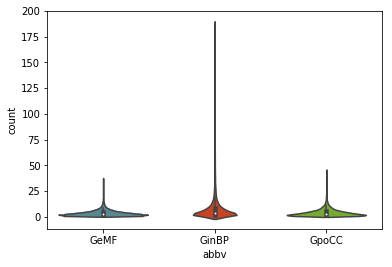

In [10]:
sns.violinplot(x='abbv', y='count', data=terms_per_gene);

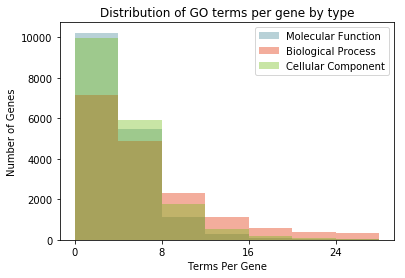

In [11]:
lim = 31

# Ensure around 15 bins...
i = 1
while (lim // i) > 9:
    i += 1

bins = np.arange(0, lim+1, i)


sns.distplot(terms_per_gene.query('count <= @lim and abbv == "GeMF"')['count'].fillna(0), 
             label='Molecular Function', kde=False, bins=bins)

sns.distplot(terms_per_gene.query('count <= @lim and abbv == "GinBP"')['count'].fillna(0), 
             label='Biological Process', kde=False, bins=bins)

sns.distplot(terms_per_gene.query('count <= @lim and abbv == "GpoCC"')['count'].fillna(0), 
             label='Cellular Component', kde=False, bins=bins)

plt.xlabel('Terms Per Gene')
plt.ylabel('Number of Genes')
plt.title('Distribution of GO terms per gene by type')
plt.xticks(bins[::2].tolist())

plt.legend();

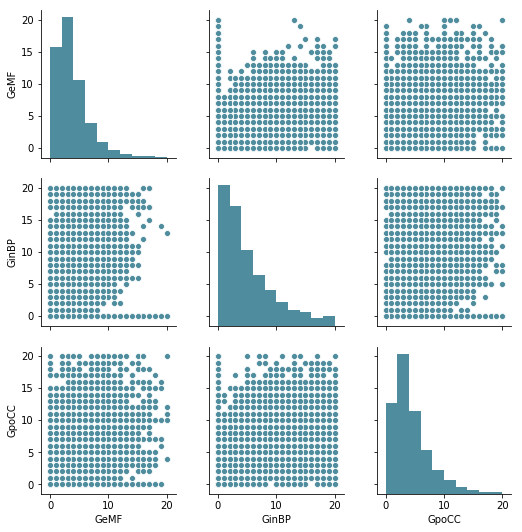

In [12]:
pivot_terms = terms_per_gene.query('count <= 20').pivot(index='start_id', columns='abbv', values='count')
sns.pairplot(pivot_terms.fillna(0));

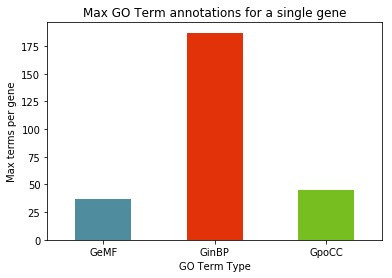

In [13]:
terms_per_gene.groupby('abbv')['count'].max().plot(kind='bar', color=colors);
plt.xlabel('GO Term Type')
plt.ylabel('Max terms per gene')
plt.xticks(rotation=0)
plt.title('Max GO Term annotations for a single gene');

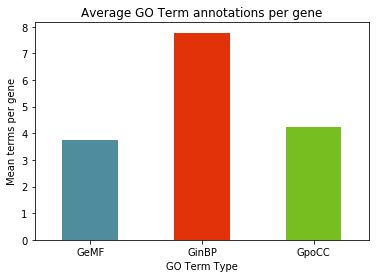

In [14]:
terms_per_gene.groupby('abbv')['count'].mean().plot(kind='bar', color=colors);
plt.xlabel('GO Term Type')
plt.ylabel('Mean terms per gene')
plt.xticks(rotation=0)
plt.title('Average GO Term annotations per gene');

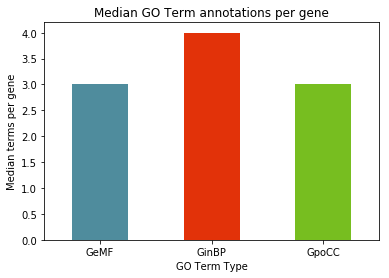

In [15]:
terms_per_gene.groupby('abbv')['count'].median().plot(kind='bar', color=colors);
plt.xlabel('GO Term Type')
plt.ylabel('Median terms per gene')
plt.xticks(rotation=0)
plt.title('Median GO Term annotations per gene');

In [16]:
head(load_dir.joinpath('interpro2go.txt'), n_lines=6)

!date: 2019/03/22 10:12:05
!Mapping of InterPro entries to GO
!
InterPro:IPR000003 Retinoid X receptor/HNF4 > GO:DNA binding ; GO:0003677
InterPro:IPR000003 Retinoid X receptor/HNF4 > GO:steroid hormone receptor activity ; GO:0003707
InterPro:IPR000003 Retinoid X receptor/HNF4 > GO:zinc ion binding ; GO:0008270



In [17]:
# Delimiters are garbage in this file... They are the first space on the line ' ', 
# then ' > ', and ' ; '. We can use a regex to get the second and 3rd dels... but I'll have to manually 
# take care of the first... Whoever thoguht that was a good idea needs a talking to....

ipr_to_go = pd.read_csv(load_dir.joinpath('interpro2go.txt'), sep='\ \>\ |\ ;\ ', engine='python',
                         comment='!', names=['ip_info', 'go_name', 'go_id'])

# Split on the first space, and rejoin
ipr_to_go['ip_id'] = ipr_to_go['ip_info'].str.split(' ', expand=True)[0]
ipr_to_go['ip_name'] = ipr_to_go['ip_info'].apply(lambda i: ' '.join(i.split(' ')[1:]))

# Remove the dual-info line and return proper column order
ipr_to_go = ipr_to_go.drop([c for c in ipr_to_go if '_info' in c], axis=1)[['ip_id', 'ip_name', 'go_name', 'go_id']]

In [18]:
ipr_to_go

,ip_id,ip_name,go_name,go_id
0,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:DNA binding,GO:0003677
1,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:steroid hormone receptor activity,GO:0003707
2,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:zinc ion binding,GO:0008270
3,InterPro:IPR000003,Retinoid X receptor/HNF4,"GO:regulation of transcription, DNA-templated",GO:0006355
4,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:nucleus,GO:0005634
5,InterPro:IPR000006,"Metallothionein, vertebrate",GO:metal ion binding,GO:0046872
6,InterPro:IPR000009,Protein phosphatase 2A regulatory subunit PR55,GO:protein phosphatase regulator activity,GO:0019888
7,InterPro:IPR000009,Protein phosphatase 2A regulatory subunit PR55,GO:protein phosphatase type 2A complex,GO:0000159
8,InterPro:IPR000010,Cystatin domain,GO:cysteine-type endopeptidase inhibitor activity,GO:0004869
9,InterPro:IPR000011,Ubiquitin/SUMO-activating enzyme E1,GO:ubiquitin-like modifier activating enzyme a...,GO:0008641


In [19]:
go_ids = all_nodes['id'].str.startswith('GO:')
go_to_onto = all_nodes[go_ids].set_index('id')['label'].to_dict()
go_ids = all_nodes[go_ids]['id'].values

In [20]:
len(ipr_to_go), len(ipr_to_go.query('go_id in @go_ids'))

(34162, 34117)

In [21]:
ipr_to_go['go_ontology'] = ipr_to_go['go_id'].map(go_to_onto)

In [22]:
terms_per_fam = ipr_to_go.groupby(['ip_id', 'go_ontology']).apply(len)
terms_per_fam = terms_per_fam.to_frame().reset_index().rename(columns={0: 'count'})

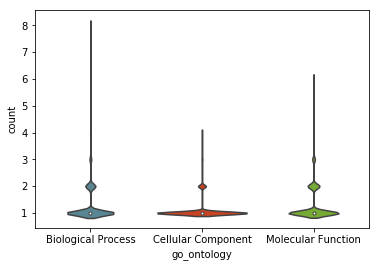

In [23]:
sns.violinplot(x='go_ontology', y='count', data=terms_per_fam);

In [24]:
gene_ids = all_nodes.query('label == "Gene"')['id'].unique()
len(gene_ids)

516505

In [25]:
# Human gene edge index
idx = edges['organism_id'].str.contains('9606').fillna(False)

hgene_edge_ids = edges[idx][['start_id', 'end_id']].stack().unique()

hgenes = set(gene_ids) & set(hgene_edge_ids)
len(hgenes)

23329

In [26]:
import biothings_client

mg = biothings_client.get_client('gene')

In [27]:
qr = load_api_results(out_dir.joinpath('mygene_interpro_results_{}.pkl'), scrape_function=mg.getgenes,
                      ids=hgenes, fields='interpro.id')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-23329...done.


In [28]:
qr[0]

{'query': '23022',
 '_id': '23022',
 '_score': 20.102285,
 'interpro': [{'id': 'IPR003598'},
  {'id': 'IPR003599'},
  {'id': 'IPR007110'},
  {'id': 'IPR013098'},
  {'id': 'IPR013783'},
  {'id': 'IPR033017'},
  {'id': 'IPR036179'}]}

In [29]:
from collections import Counter
c = Counter([type(r.get('interpro')) for r in qr])
c

Counter({list: 15636, NoneType: 4678, dict: 3015})

In [30]:
gene_ids = []
interpro_ids = []

for result in qr:
    gene_id = result['query']
    interpro_info = result.get('interpro')
    
    if type(interpro_info) == dict:
        gene_ids.append(gene_id)
        interpro_ids.append(interpro_info.get('id'))
        
    elif type(interpro_info) == list:
        for xref in interpro_info:
            gene_ids.append(gene_id)
            interpro_ids.append(xref.get('id'))

gene_to_interpro = pd.DataFrame({'gene_id': gene_ids, 'interpro_id': interpro_ids})

In [31]:
gene_to_interpro.head(3)

,gene_id,interpro_id
0,23022,IPR003598
1,23022,IPR003599
2,23022,IPR007110


In [32]:
ipr_info = pd.read_csv(load_dir.joinpath('entry.list.tsv'), sep='\t')
ipr_info.columns = [c.lower() for c in ipr_info.columns]
ipr_info.head(2)

,entry_ac,entry_type,entry_name
0,IPR000126,Active_site,"Serine proteases, V8 family, serine active site"
1,IPR000138,Active_site,"Hydroxymethylglutaryl-CoA lyase, active site"


In [33]:
ipr_info['entry_type'].value_counts()

Family                    21769
Domain                    10637
Homologous_superfamily     3078
Conserved_site              688
Repeat                      316
Active_site                 132
Binding_site                 76
PTM                          17
Name: entry_type, dtype: int64

In [34]:
merge = pd.merge(gene_to_interpro, ipr_info, how='left', left_on='interpro_id', right_on='entry_ac')

In [35]:
merge.head(2)

,gene_id,interpro_id,entry_ac,entry_type,entry_name
0,23022,IPR003598,IPR003598,Domain,Immunoglobulin subtype 2
1,23022,IPR003599,IPR003599,Domain,Immunoglobulin subtype


In [36]:
merge['entry_type'].value_counts()

Domain                    29508
Homologous_superfamily    22175
Family                    17146
Conserved_site             3838
Repeat                     2178
Active_site                1024
Binding_site                839
PTM                         156
Name: entry_type, dtype: int64

In [37]:
ipr_to_go.head(2)

,ip_id,ip_name,go_name,go_id,go_ontology
0,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:DNA binding,GO:0003677,Molecular Function
1,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:steroid hormone receptor activity,GO:0003707,Molecular Function


In [38]:
ipr_info['ip_id'] = 'InterPro:' + ipr_info['entry_ac']
ipr_to_go_1 = ipr_to_go.merge(ipr_info, how='left', on='ip_id')
len(ipr_to_go_1)

34162

In [39]:
ipr_to_go_1['entry_type'].count()

34118

In [40]:
ipr_to_go_1['entry_type'].value_counts()

Family                    25416
Domain                     5755
Homologous_superfamily     1704
Conserved_site              896
Active_site                 139
Binding_site                106
Repeat                       92
PTM                          10
Name: entry_type, dtype: int64

In [41]:
gene_fams = merge.query('entry_type == "Family"')
fams_per_gene = gene_fams.groupby('gene_id').apply(len).to_frame()
fams_per_gene['metric'] = 'Fams per gene'
genes_per_fam = gene_fams.groupby('entry_ac').apply(len).to_frame()
genes_per_fam['metric'] = 'Genes per fam'

counts = pd.concat([genes_per_fam, fams_per_gene]).rename(columns={0: 'counts'})

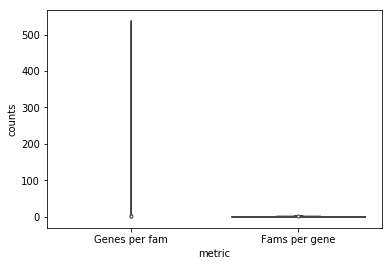

In [42]:
sns.violinplot(x='metric', y='counts', data=counts)

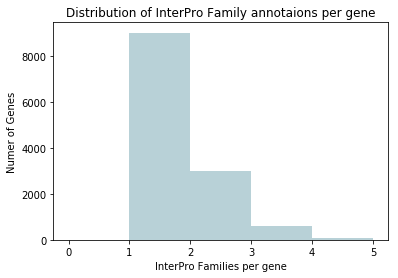

In [43]:
bins = np.arange(0, fams_per_gene[0].max()+1, 1)
sns.distplot(fams_per_gene[0], kde=False, bins=bins)
plt.xticks(bins)
plt.xlabel('InterPro Families per gene')
plt.ylabel('Numer of Genes')
plt.title('Distribution of InterPro Family annotaions per gene');

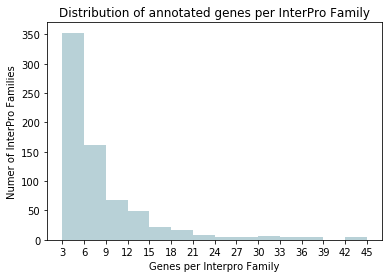

In [44]:
min_val = 3
max_val = 50
subset = genes_per_fam[0][(min_val < genes_per_fam[0]) & (genes_per_fam[0] < max_val)]


bins = np.arange(min_val, subset.max(), 3)
sns.distplot(subset, kde=False, bins=bins)
plt.xticks(bins)
plt.xlabel('Genes per Interpro Family')
plt.ylabel('Numer of InterPro Families')
plt.title('Distribution of annotated genes per InterPro Family');

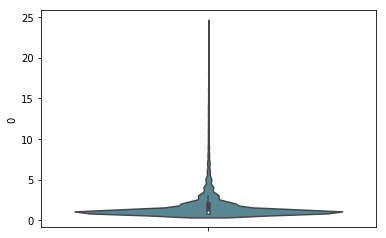

In [45]:
sns.violinplot(y=genes_per_fam[genes_per_fam[0] < 25][0])

In [46]:
fam_terms = ipr_info.query('entry_type == "Family"')
len(fam_terms)

21769

In [47]:
fam_nodes = fam_terms[['ip_id', 'entry_name']].copy()
fam_nodes.columns = [c.split('_')[-1] for c in fam_nodes.columns]
fam_nodes['label'] = 'Protein Family'
fam_nodes.head(2)

,id,name,label
11533,InterPro:IPR000003,Retinoid X receptor/HNF4,Protein Family
11534,InterPro:IPR000006,"Metallothionein, vertebrate",Protein Family


In [48]:
edge_map = {'Molecular Function': 'enables_PFeMF',
            'Biological Process': 'involved_in_PFinBP',
            'Cellular Component': 'part_of_PFpoCC'}

fam_ids = fam_nodes['id'].unique()
edges_fam_to_go = ipr_to_go.query('ip_id in @fam_ids').copy()
edges_fam_to_go['type'] = edges_fam_to_go['go_ontology'].map(edge_map)

edges_fam_to_go = edges_fam_to_go[['ip_id', 'go_id', 'type']]
edges_fam_to_go = edges_fam_to_go.rename(columns={'ip_id': 'start_id', 'go_id': 'end_id'})
edges_fam_to_go.head(2)

,start_id,end_id,type
0,InterPro:IPR000003,GO:0003677,enables_PFeMF
1,InterPro:IPR000003,GO:0003707,enables_PFeMF


In [49]:
len(edges_fam_to_go)

25416

In [50]:
edges_fam_to_go['source'] = 'InterPro'
edges_fam_to_go['evidence'] = 'curated'

In [51]:
gene_to_interpro['interpro_id'] = 'InterPro:' + gene_to_interpro['interpro_id']
edges_gene_to_fam = gene_to_interpro.query('interpro_id in @fam_ids').copy()
edges_gene_to_fam = edges_gene_to_fam.rename(columns={'gene_id': 'start_id', 'interpro_id': 'end_id'})
edges_gene_to_fam['type'] = 'part_of_GpoPF'
edges_gene_to_fam.head(2)

,start_id,end_id,type
7,10880,InterPro:IPR004000,part_of_GpoPF
8,10880,InterPro:IPR027680,part_of_GpoPF


In [52]:
len(gene_to_interpro)

77370

In [53]:
# mygene.info actually sources their interpro annotaions from ensembel
gene_to_interpro['source'] = 'ensembl'
gene_to_interpro['evidence'] = 'curated'

# Putting it all together

In [54]:
new_nodes_df = fam_nodes
new_edges_df = pd.concat([edges_fam_to_go, edges_gene_to_fam], sort=False)

In [55]:
new_nodes_df.head(2)

,id,name,label
11533,InterPro:IPR000003,Retinoid X receptor/HNF4,Protein Family
11534,InterPro:IPR000006,"Metallothionein, vertebrate",Protein Family


In [56]:
new_edges_df.head(2)

,start_id,end_id,type,source,evidence
0,InterPro:IPR000003,GO:0003677,enables_PFeMF,InterPro,curated
1,InterPro:IPR000003,GO:0003707,enables_PFeMF,InterPro,curated


In [57]:
new_edges_df['type'].value_counts()

part_of_GpoPF         17146
involved_in_PFinBP    10773
enables_PFeMF          9485
part_of_PFpoCC         5123
Name: type, dtype: int64

In [58]:
print('Total number of new edges: {:,}'.format(len(new_edges_df)))
print('Number of unique new edges: {:,}'.format(len(new_edges_df.drop_duplicates(subset=['start_id', 'end_id', 'type']))))

Total number of new edges: 42,562
Number of unique new edges: 42,562


In [59]:
all_node_ids = set(all_nodes['id']) | set(new_nodes_df['id'])

print(len(new_edges_df))
new_edges_df_filt = new_edges_df.query('start_id in @all_node_ids and end_id in @all_node_ids').copy()
print(len(new_edges_df_filt))

42562
42527


In [60]:
len(new_edges_df) - len(new_edges_df_filt)

35

In [61]:
new_edges_df.query('start_id not in @all_node_ids or end_id not in @all_node_ids').head(5)

,start_id,end_id,type,source,evidence
1594,InterPro:IPR000983,GO:0008565,NaN,InterPro,curated
2686,InterPro:IPR001639,GO:0008565,NaN,InterPro,curated
4105,InterPro:IPR002416,GO:0008565,NaN,InterPro,curated
4282,InterPro:IPR002528,GO:0015238,NaN,InterPro,curated
5314,InterPro:IPR003369,GO:0008565,NaN,InterPro,curated


GO terms that aren't in the network.... Drop them...

In [62]:
all_nodes_out = pd.concat([all_nodes, new_nodes_df], sort=False)
all_nodes_out.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
0,MESH:C089250,(0.017ferrocene)amylose,Compound,D01.490.200/C089250|D02.691.550.200/C089250|D0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C114385,001-C8-NBD,Compound,D03.383.129.462.580/C114385|D12.644.456/C114385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
new_edges_df_filt['abbv'] = new_edges_df_filt['type'].apply(lambda s: s.split('_')[-1])
all_edges = pd.concat([edges, new_edges_df_filt], sort=False)
all_edges.head(2)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,abbv,source,evidence,direct_evidence,corrected_pvalue,inference_gene_symbol,qualifier,db_reference,evidence_code,with_or_from,date,assigned_by,experiments,support_type
0,MESH:C000121,4313,decreases_activity_CdaG,decreases^activity,25899827,9606,CdaG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C000121,4313,decreases_expression_CdeG,decreases^expression,25899827,9606,CdeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
len(all_node_ids) == len(all_nodes_out)

True

In [65]:
all_edge_ids = all_edges[['start_id', 'end_id']].stack()
filt_nodes_out = all_nodes_out.query('id in @all_edge_ids')
len(filt_nodes_out)

126431

# Save to Disk

In [66]:
gt.add_colons(new_nodes_df, id_name='identifier').to_csv(out_dir.joinpath('new_nodes.csv'), index=False)
gt.add_colons(new_edges_df).to_csv(out_dir.joinpath('new_edges.csv'), index=False)

In [67]:
gt.add_colons(all_nodes_out, id_name='identifier').to_csv(out_dir.joinpath('nodes_all.csv'), index=False)
gt.add_colons(filt_nodes_out, id_name='identifier').to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)

gt.add_colons(all_edges).to_csv(out_dir.joinpath('edges.csv'), index=False)